In [1]:
from adabmDCA.fasta import get_tokens, import_from_fasta, compute_weights
from adabmDCA.stats import get_freq_single_point, get_freq_two_points, get_correlation_two_points, extract_Cij_from_freq
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.io import save_params, save_chains
from adabmDCA.plot import plot_PCA
from adabmDCA import get_seqid

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd     

# ---------- Device / dtype setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = get_dtype("float32")
tokens = get_tokens("protein")

from adabmDCA.fasta import get_tokens
from adabmDCA.utils import get_device, get_dtype
from adabmDCA.io import load_params, import_from_fasta
from adabmDCA.fasta import encode_sequence, decode_sequence
from adabmDCA.functional import one_hot
from adabmDCA.statmech import compute_energy

import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import os
import sys

# Move up one level to the 'my_project' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path so Python can find 'src'
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"System path updated to include: {project_root}")
from src import compute_gibbs_probabilities, simulate_gibbs_trajectories


from src import pearson_correlation_1d, cosine_sim, compute_cosine_curve
from src import calculate_forces_and_noises, generate_dms_and_project_batch_timed

System path updated to include: /home/ldibari/ldibari/ProtLatDyn


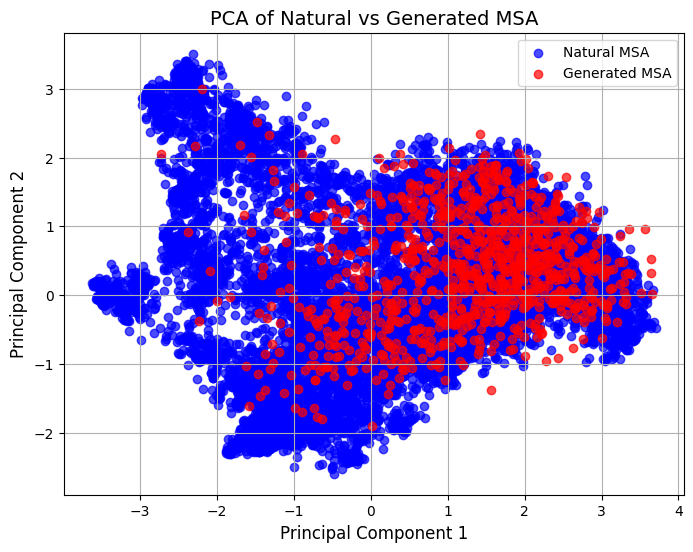

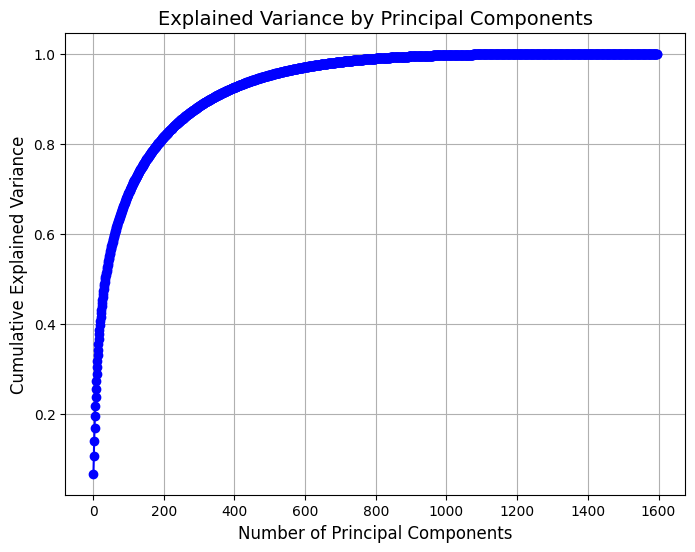

Explained Variance Ratio by each principal component:
[6.6902176e-02 3.9510638e-02 3.2980386e-02 ... 1.4949245e-17 5.6837089e-18
 8.7676058e-19]


In [2]:

params = load_params("../data/DBD_full/params.dat", tokens=tokens, device=device, dtype=dtype)

# --- Load natural MSA ---
nat_fasta = f"../data/DBD_alignment.uniref90.cov80.nodupl.fasta"
nat_headers, nat_sequences = import_from_fasta(nat_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
nat_msa_enc = torch.tensor(nat_sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
nat_msa_oh = one_hot(nat_msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten MSA for PCA (L, q components)
L, q = nat_msa_oh.shape[1], nat_msa_oh.shape[2]  # L: sequence length, q: number of residues
nat_msa_flat = nat_msa_oh.view(len(nat_msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence

# Perform PCA on the one-hot encoded MSA data
pca = PCA(n_components=L*q)  # Adjust the number of components as needed
nat_msa_proj = pca.fit_transform(nat_msa_flat)  # Project the data onto the principal components

# --- Load generated MSA ---
generated_fasta = f"../data/DBD_full/sampling_samples.fasta"
headers, sequences = import_from_fasta(generated_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
msa_enc = torch.tensor(sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
msa_oh = one_hot(msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten generated MSA for PCA
msa_flat = msa_oh.view(len(msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence

# Project the generated sequences onto the same principal components
msa_proj = pca.transform(msa_flat)

# --- Visualize PCA Results ---
# Scatter plot of first two principal components (PC1 vs PC2)
plt.figure(figsize=(8, 6))
plt.scatter(nat_msa_proj[:, 0], nat_msa_proj[:, 1], color='blue', label='Natural MSA', alpha=0.7)
plt.scatter(msa_proj[:, 0], msa_proj[:, 1], color='red', label='Generated MSA', alpha=0.7)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.title('PCA of Natural vs Generated MSA', fontsize=14)
plt.grid(True)
plt.show()

# --- Plot Explained Variance ---
# Plot explained variance ratio for the principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Principal Components', fontsize=14)
plt.grid(True)
plt.show()

# --- Explained Variance (for PCA analysis) ---
print("Explained Variance Ratio by each principal component:")
print(pca.explained_variance_ratio_)

In [3]:
def calculate_forces_pcs(
    seqs: torch.Tensor,      # (M_big, L, q)
    gibbs: torch.Tensor,     # (L, M_big, q)
    pca,                     # Trained PCA object
    device: torch.device,
    M_batch: int = 100
):
    import gc

    all_forces = []
    all_pcs = []

    M_big, L, q = seqs.shape

    # Cap batch size automatically
    M_batch = min(M_batch, M_big)

    # Pre-permute gibbs once for efficiency: (L, M_big, q) -> (M_big, L, q)
    gibbs = gibbs.permute(1, 0, 2)

    # Loop in adaptive chunks
    for start in range(0, M_big, M_batch):
        end = min(start + M_batch, M_big)

        seqs_batch = seqs[start:end]           # (m, L, q)
        gibbs_batch = gibbs[start:end]         # (m, L, q)
        m = end - start

        # PCA projections for DMS
        dms_pc = torch.stack(
            generate_dms_and_project_batch_timed(seqs_batch, pca)
        ).to(device)                           # (m, Lq+1, lq)

        # Displacements
        dms_displ = dms_pc[:, 1:, :] - dms_pc[:, 0, :].unsqueeze(1)

        # Expand gibbs: (m, L, q) -> (m, L*q, 1)
        W = gibbs_batch.reshape(m, L * q).unsqueeze(-1)

        # Weighted average force
        force = (W * dms_displ).sum(dim=1) / W.sum(dim=1)

        # Collect
        all_forces.append(force)
        all_pcs.append(dms_pc[:, 0, :])

        # Cleanup
        del dms_displ, W, force, dms_pc, seqs_batch, gibbs_batch
        gc.collect()
        torch.cuda.empty_cache()

    final_forces = torch.cat(all_forces, dim=0)
    final_pcs = torch.cat(all_pcs, dim=0)

    return final_forces, final_pcs




In [4]:
M_big = 1000
beta_eq = 1.0
molec_time = True
# M, L, T, q
gibbs_big = compute_gibbs_probabilities(nat_msa_oh[:M_big], params, beta=beta_eq, remove_self_loop=True)
gibbs_big.shape

f, pcs = calculate_forces_pcs(msa_oh[:M_big], gibbs_big[:M_big], pca, device = device)